# Análisis y predicción de resultados en League of Legends

In [1]:
## Imports
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_columns = 999
pd.set_option('display.max_columns', None)


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold

## Load data

In [3]:
data = pd.read_csv('./data/2021_LoL_esports_match_data_from_OraclesElixir_20210827.csv')
data.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15;;
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021.0,NaN,0.0,2021-01-02 07:40:39,1.0,10.25,1.0,Blue,top,Khan,DWG KIA,Mordekaiser,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782.0,1.0,7.0,1.0,3.0,23.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,20435.0,688.0471,0.276268,717.7441,933.9731,13.0,0.4377,5.0,0.1684,7.0,25.0,0.8418,12065.0,8154.0,274.5455,0.196019,10875.0,NaN,209.0,193.0,16.0,8.0,5.0,7.0370,3421.0,5043.0,73.0,2985.0,4493.0,72.0,436.0,550.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5407.0,7536.0,114.0,4659.0,7592.0,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1;;
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021.0,NaN,0.0,2021-01-02 07:40:39,1.0,10.25,2.0,Blue,jng,Canyon,DWG KIA,Graves,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782.0,1.0,7.0,1.0,5.0,23.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,13944.0,469.4949,0.188514,559.0909,400.5387,10.0,0.3367,14.0,0.4714,10.0,46.0,1.5488,13944.0,10033.0,337.8114,0.241189,13850.0,NaN,259.0,41.0,218.0,110.0,43.0,8.7205,3497.0,4314.0,87.0,3055.0,3059.0,62.0,442.0,1255.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,6974.0,8232.0,146.0,4854.0,4827.0,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3;;
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021.0,NaN,0.0,2021-01-02 07:40:39,1.0,10.25,3.0,Blue,mid,ShowMaker,DWG KIA,Zoe,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782.0,1.0,5.0,0.0,8.0,23.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,16039.0,540.0337,0.216837,285.4545,282.6936,11.0,0.3704,8.0,0.2694,4.0,59.0,1.9865,14274.0,10363.0,348.9226,0.249122,12700.0,NaN,299.0,250.0,49.0,17.0,24.0,10.0673,3784.0,5171.0,114.0,3301.0,4822.0,91.0,483.0,349.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,6591.0,7827.0,158.0,5013.0,7473.0,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0;;
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021.0,NaN,0.0,2021-01-02 07:40:39,1.0,10.25,4.0,Blue,bot,Ghost,DWG KIA,Miss Fortune,Aatrox,Kai'Sa,Pantheon,Aphelios,Lucian,1782.0,1.0,3.0,2.0,11.0,23.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7744,0.9091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,17202.0,579.1919,0.232560,339.6296,291.8855,15.0,0.5051,5.0,0.1684,7.0,34.0,1.1448,13097.0,9186.0,309.2929,0.220828,11925.0,NaN,292.0,265.0,27.0,17.0,4.0,9.8

El dataset divide cada encuentro (que tiene el mismo 'gameid') en 12 filas dependiendo del rol de cada jugador 5 jugadores por equipo y 2 filas extras para las cifras globales del cada equipo.

Únicamente seleccionaremos aquellas filas cuya 'datacompleteness' sea 'complete'. 
No tiene sentido agrupar filas que sabemos que no estan completas ya que pueden aportar problemas. 

In [4]:
data = data[data['datacompleteness'] == 'complete']

Para analizar las columnas únicamente utilizaremos las filas que hacen referencia a los equipos, 
ya que aportan información más general y valiosa. 

In [5]:
equipos = data[data['position'] == 'team']

## Analisis Exploratorio de Datos 

### Eliminación de columnas

Eliminaremos variables que sólo son útiles a nivel de jugador, pero no tanto de equipo. También otras que 
aportan información redundante, ya que si un equipo ha conseguido un objetivo el otro no puede también 
conseguirlo(empiezan por opp_). Y por último eliminaremos también columnas cuya información no es representativa
de un buen rendimiento, porque una partida más larga implica mas recursos, pero no significa que haya sido bien
ejecutada. 

In [6]:
data.columns.values

array(['gameid', 'datacompleteness', 'url', 'league', 'year', 'split',
       'playoffs', 'date', 'game', 'patch', 'playerid', 'side',
       'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3',
       'ban4', 'ban5', 'gamelength', 'result', 'kills', 'deaths',
       'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills',
       'quadrakills', 'pentakills', 'firstblood', 'firstbloodkill',
       'firstbloodassist', 'firstbloodvictim', 'team kpm', 'ckpm',
       'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes',
       'opp_elementaldrakes', 'infernals', 'mountains', 'clouds',
       'oceans', 'dragons (type unknown)', 'elders', 'opp_elders',
       'firstherald', 'heralds', 'opp_heralds', 'firstbaron', 'barons',
       'opp_barons', 'firsttower', 'towers', 'opp_towers',
       'firstmidtower', 'firsttothreetowers', 'turretplates',
       'opp_turretplates', 'inhibitors', 'opp_inhibitors',
       'damagetochampions', 'dpm', 'damageshare', 'damagetakenpe

In [7]:
# Nos quedamos con estas variables para explorar, aunque eliminaremos otras más adelante.

data2 = data[['gameid', 'league', 'side', 'position', 'champion', 'team',
       'gamelength', 'result',
       'team kpm', 
       'dpm',  
       'vspm',
       'totalgold',
       'earned gpm',
       'minionkills', 'monsterkills', 
       'golddiffat10','golddiffat15']]

### Datos nulos

In [8]:
def checkNulls(df):
    obj = df.isna().sum()
    for key,value in obj.iteritems():
        if(value > 0):
            print(key,":",value)

In [9]:
data2.columns.values

array(['gameid', 'league', 'side', 'position', 'champion', 'team',
       'gamelength', 'result', 'team kpm', 'dpm', 'vspm', 'totalgold',
       'earned gpm', 'minionkills', 'monsterkills', 'golddiffat10',
       'golddiffat15'], dtype=object)

In [10]:
checkNulls(data2)

gameid : 48
champion : 19344
dpm : 48
vspm : 12552
earned gpm : 8
minionkills : 134
monsterkills : 48


In [11]:
data2 = data2.drop_duplicates()

In [12]:
data2 = data2[data2.gameid.notnull()]

data2[['dpm']] = data2[['dpm']].fillna(
    value = np.nanmedian(data2['dpm']))
data2[['champion']] = data2[['champion']].fillna(value = 'team')
data2[['earned gpm']] = data2[['earned gpm']].fillna(
    value = np.nanmedian(data2['earned gpm']))
data2[['vspm']] = data2[['vspm']].fillna(
    value = np.nanmedian(data2['vspm']))
data2[['minionkills']] = data2[['minionkills']].fillna(
    value = np.nanmedian(data2['minionkills']))
data2[['monsterkills']] = data2[['monsterkills']].fillna(
    value = np.nanmedian(data2['monsterkills']))

In [13]:
checkNulls(data2)

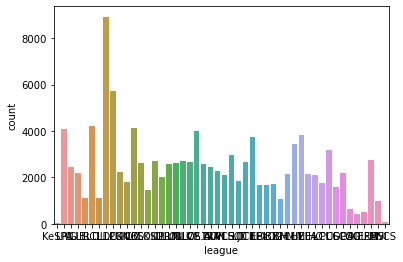

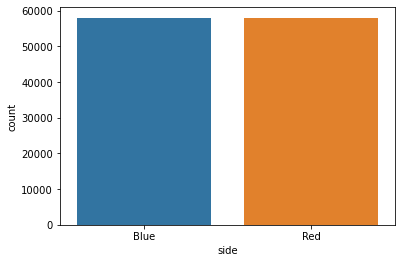

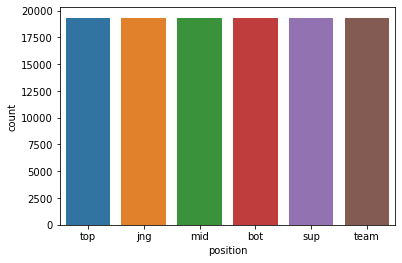

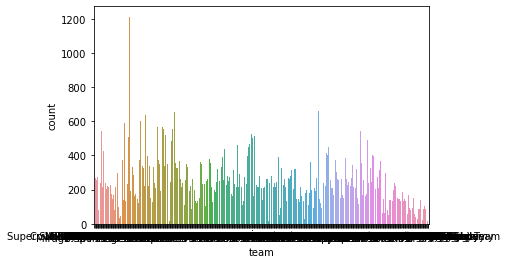

In [14]:

cat_cols = ['league', 'side', 'position', 'team']

""" Variables categóricas """

for col in cat_cols: 
    sns.countplot(data2[col])
    plt.show()

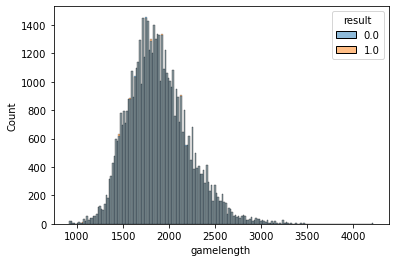

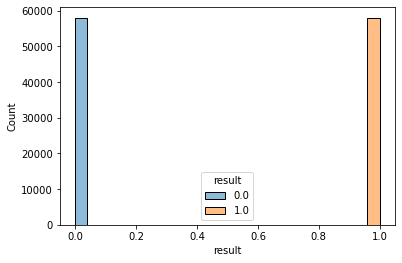

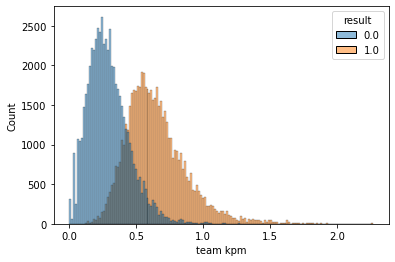

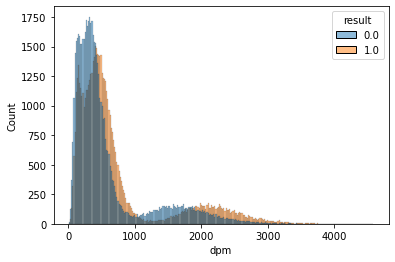

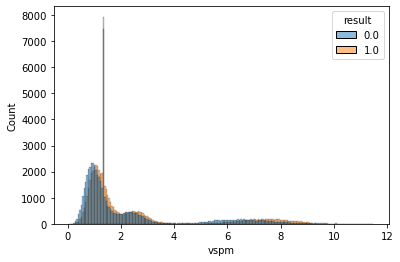

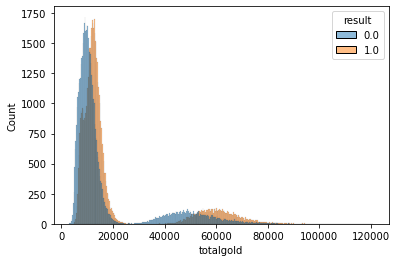

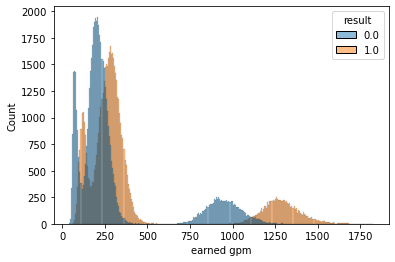

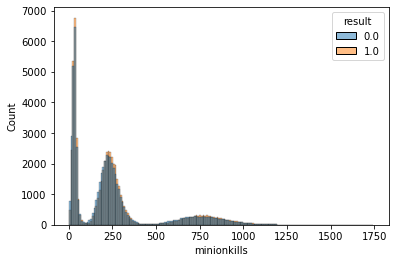

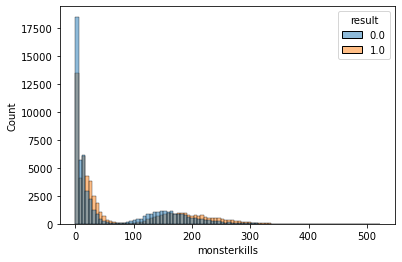

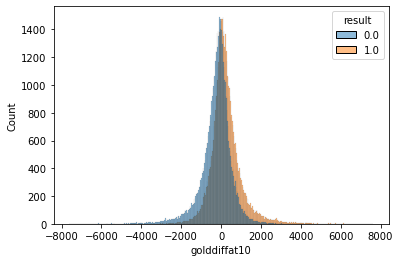

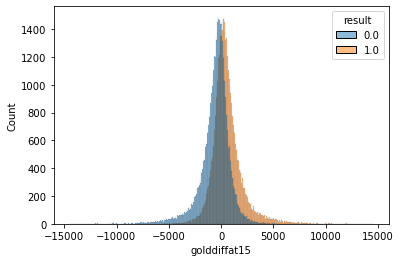

In [15]:
num_cols = ['gamelength', 'result',
       'team kpm', 
       'dpm',  
       'vspm',
       'totalgold',
       'earned gpm',
       'minionkills', 'monsterkills', 
       'golddiffat10','golddiffat15']
for col in num_cols: 
    sns.histplot(data = data2, x=col, hue='result')
    plt.show()

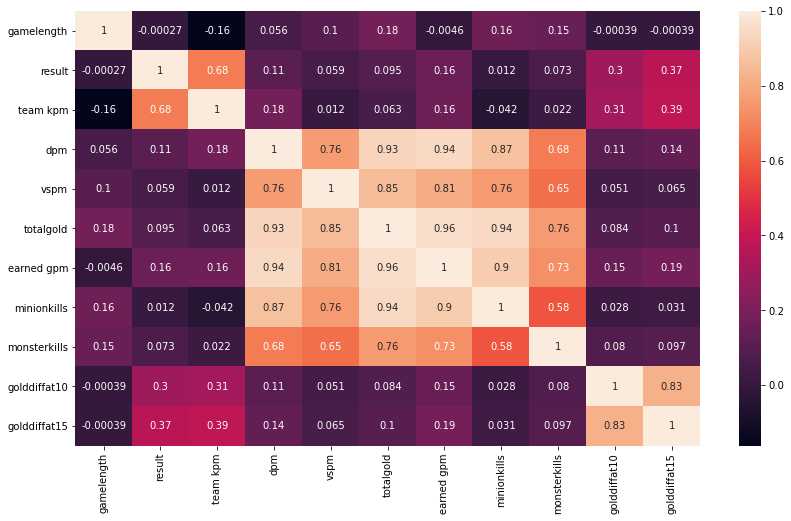

In [16]:
# Correlaciones
plt.figure(figsize = (14, 8))
sns.heatmap(data2.corr(), annot = True)
plt.show()

#### Win ratio

In [17]:
def setWinRatio(data):
    df2 = data[data['position'] == 'team'].copy(deep=True)
    df2 = df2.reset_index()
    df2['win_count'] = df2.groupby(['side', 'team'])['result'].cumsum()
    df2['games_played'] = df2.groupby(['side', 'team']).cumcount()+1
    df2['win_ratio'] = df2['win_count'] / df2['games_played']
    return pd.merge(data[data['position']=='team'], 
                    df2[['gameid', 'side', 'team', 'win_ratio']], 
                    on=['gameid', 'side', 'team'], how='right')

In [18]:
dataTeams = setWinRatio(data2)

In [19]:
dataTeams[dataTeams['team'] == 'Vodafone Giants.Spain'][['gameid', 'side', 'result', 'team', 'win_ratio']].head(10)

,gameid,side,result,team,win_ratio
761,ESPORTSTMNT01/1692355,Red,1.0,Vodafone Giants.Spain,1.000000
1058,ESPORTSTMNT01/1693124,Blue,0.0,Vodafone Giants.Spain,0.000000
1190,ESPORTSTMNT01/1683756,Blue,0.0,Vodafone Giants.Spain,0.000000
1664,ESPORTSTMNT01/1731417,Blue,0.0,Vodafone Giants.Spain,0.000000
2162,ESPORTSTMNT01/1722637,Blue,1.0,Vodafone Giants.Spain,0.250000
2802,ESPORTSTMNT02/1683144,Blue,0.0,Vodafone Giants.Spain,0.200000
3202,ESPORTSTMNT02/1694863,Blue,1.0,Vodafone Giants.Spain,0.333333
3784,ESPORTSTMNT02/1696811,Blue,1.0,Vodafone Giants.Spain,0.428571
4015,ESPORTSTMNT02/1697474,Red,1.0,Vodafone Giants.Spain,1.000000
4114,ESPORTSTMNT02/1688168,Blue,0.0,Vodafone Giants.Spain,0.375000


#### Recoger campeones 

In [20]:
def getChampCompo(data):
    # Variables vacías para la transformación
    positions = ['top', 'jng', 'mid', 'bot', 'sup']
    picks = pd.DataFrame(columns = ['gameid', 'team'])

    # Recogemos los campones seleccionados
    #  - El bucle busca el campeon en las distintas posiciones y los junta en una fila
    for position in positions: 
        positionPick = data[data['position'] == position]
        positionPick = positionPick[['gameid','side', 'team', 'champion', 'result']]
        positionPick = positionPick.rename(columns={'champion': position})
        picks = pd.merge(picks, positionPick, how='right', on=['gameid', 'team'])
    picks = picks.drop(columns = ['result_x', 'result_y','side_x', 'side_y'])
    picks = picks.drop_duplicates()

    # Añadimos el win ratio de cada encuentro
    picks = picks.merge(dataTeams[['gameid', 'team', 'win_ratio']], how='left', on=['gameid', 'team'])

    # Juntamos los equipos del encuentro en la misma fila
    picks = picks[picks['team']!= 'unknown team']
    picks = pd.merge(picks, picks, on = ['gameid'], how='inner', suffixes=('_blue', '_red'))
    picks = picks[picks['result_blue'] != picks['result_red']]
    picks = picks[picks['side_red'] != 'Blue']
    picks = picks.drop(columns = ['side_blue', 'side_red', 'result_red'])
    picks = picks.drop_duplicates(subset=['gameid'], keep='first')
    return picks

In [21]:
picks = getChampCompo(data2)
picks.head()

,gameid,team_blue,top_blue,jng_blue,mid_blue,bot_blue,sup_blue,result_blue,win_ratio_blue,team_red,top_red,jng_red,mid_red,bot_red,sup_red,win_ratio_red
1,ESPORTSTMNT03/1632489,DWG KIA,Mordekaiser,Graves,Zoe,Miss Fortune,Galio,1.0,1.0,Nongshim RedForce,Ornn,Kindred,Orianna,Ezreal,Leona,0.0
5,ESPORTSTMNT03/1632500,Nongshim RedForce,Gragas,Graves,Rumble,Kai'Sa,Alistar,0.0,0.0,DWG KIA,Ornn,Olaf,Syndra,Miss Fortune,Galio,1.0
9,ESPORTSTMNT03/1632502,Nongshim RedForce,Gragas,Graves,Zoe,Yasuo,Alistar,0.0,0.0,DWG KIA,Rumble,Nidalee,Yone,Miss Fortune,Galio,1.0
13,6909-9183,Top Esports,Karma,Pantheon,Syndra,Samira,Leona,0.0,0.0,Suning,Aatrox,Nidalee,Viktor,Kai'Sa,Galio,1.0
17,6909-9184,Top Esports,Jax,Hecarim,Orianna,Samira,Alistar,0.0,0.0,Suning,Camille,Lillia,Viktor,Kai'Sa,Maokai,1.0


#### Champion Counter 

In [22]:
matchs = picks.copy(deep=True)

# Top win ratio
top = matchs[['gameid', 'top_blue', 'top_red', 'result_blue']]
top['top_win_count'] = top.groupby(['top_blue', 'top_red'])['result_blue'].cumsum()
top['top_games_played'] =  top.groupby(['top_blue', 'top_red']).cumcount()+1
top['top_blue_counter'] = top['top_win_count']/top['top_games_played']

# Jng win ratio
jng = matchs[['gameid', 'jng_blue', 'jng_red', 'result_blue']]
jng['jng_win_count'] = jng.groupby(['jng_blue', 'jng_red'])['result_blue'].cumsum()
jng['jng_games_played'] =  jng.groupby(['jng_blue', 'jng_red']).cumcount()+1
jng['jng_blue_counter'] = jng['jng_win_count']/jng['jng_games_played']

# # mid win ratio
mid = matchs[['gameid', 'mid_blue', 'mid_red', 'result_blue']]
mid['mid_win_count'] = mid.groupby(['mid_blue', 'mid_red'])['result_blue'].cumsum()
mid['mid_games_played'] =  mid.groupby(['mid_blue', 'mid_red']).cumcount()+1
mid['mid_blue_counter'] = mid['mid_win_count']/mid['mid_games_played']

## bot win ratio
bot = matchs[['gameid', 'bot_blue', 'bot_red', 'result_blue']]
bot['bot_win_count'] = bot.groupby(['bot_blue', 'bot_red'])['result_blue'].cumsum()
bot['bot_games_played'] =  bot.groupby(['bot_blue', 'bot_red']).cumcount()+1
bot['bot_blue_counter'] = bot['bot_win_count']/bot['bot_games_played']

# sup win ratio
sup = matchs[['gameid', 'sup_blue', 'sup_red', 'result_blue']]
sup['sup_win_count'] = sup.groupby(['sup_blue', 'sup_red'])['result_blue'].cumsum()
sup['sup_games_played'] =  sup.groupby(['sup_blue', 'sup_red']).cumcount()+1
sup['sup_blue_counter'] = sup['sup_win_count']/sup['sup_games_played']

matchs['top_blue_counter'] = top['top_blue_counter']
matchs['jng_blue_counter'] = jng['jng_blue_counter']
matchs['mid_blue_counter'] = mid['mid_blue_counter']
matchs['bot_blue_counter'] = bot['bot_blue_counter']
matchs['sup_blue_counter'] = sup['sup_blue_counter']
matchs['team_counter'] = (top['top_blue_counter'] + 
                          jng['jng_blue_counter'] +
                          mid['mid_blue_counter'] +
                          bot['bot_blue_counter'] +
                          sup['sup_blue_counter']) / 5


## Eliminamos nos nombres de los campeones y el gameid, no los vamos a usar más.
matchs_clean =  matchs.drop(columns = ['gameid', 'top_blue', 'jng_blue', 'mid_blue', 'bot_blue',
       'sup_blue','top_red','jng_red', 'mid_red', 'bot_red', 'sup_red','top_blue_counter',
        'jng_blue_counter','mid_blue_counter','bot_blue_counter', 'sup_blue_counter'])

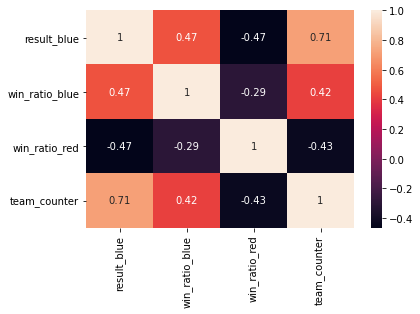

In [23]:
""" Correlaciones """
plt.figure(figsize = (6,4))

sns.heatmap(matchs_clean.corr(), annot = True)
plt.show()

### Construcción de un primer modelo 

In [24]:
def model_evaluation(models, scoring='accuracy', confusion=False):
    names = []
    cv_results = []

    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=99)
        results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        cv_results.append(results)
        names.append(name)
        print(name + ': ' + str(results.mean()))

        if confusion == True: 
            y_pred = cross_val_predict(model, X, y, cv=kfold)
            print(confusion_matrix(y_pred, y))   

    plt.figure(figsize=(8, 8))
    plt.ylabel(scoring)
    plt.boxplot(cv_results)
    plt.xticks(range(1, len(names)+1), names)
    plt.show()

In [25]:
matchs_clean.columns.values

array(['team_blue', 'result_blue', 'win_ratio_blue', 'team_red',
       'win_ratio_red', 'team_counter'], dtype=object)

Ejecutamos un bucle con los modelos para elegir el más óptimo para trabajar

LR: 0.9017303142501971
[[3947  445]
 [ 486 4596]]
DTC: 0.8758721746220577
[[3857  599]
 [ 576 4442]]
KNN: 0.8009296512638178
[[3406  859]
 [1027 4182]]
LDA: 0.8754491198053813
[[3824  571]
 [ 609 4470]]
NB: 0.5710386786610171
[[3693 3324]
 [ 740 1717]]
RFC: 0.9025758669393464
[[3956  433]
 [ 477 4608]]
SVC: 0.8922307397555682
[[3888  476]
 [ 545 4565]]


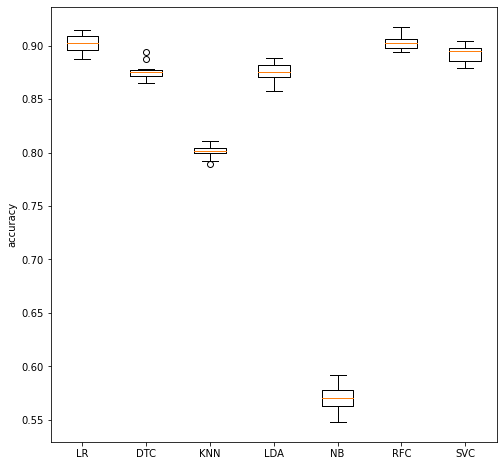

In [26]:
team_cols = ['team_blue', 'team_red']

matchs2 = pd.get_dummies(matchs_clean, columns = team_cols)
matchs2
y = matchs2['result_blue']
X = matchs2.drop(columns=['result_blue'])



models = [('LR', LogisticRegression()), 
          ('DTC', DecisionTreeClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LDA', LinearDiscriminantAnalysis()),
          ('NB', GaussianNB()),
          ('RFC', RandomForestClassifier()),
          ('SVC', SVC())]

model_evaluation(models, confusion = True)


In [27]:
# Aplicamos la transformación únicamente a las variables relativas a los nombres de los equipos

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder


team_cols = ['team_blue', 'team_red']

ctransformer  = ColumnTransformer([
    ('encoder1', OneHotEncoder(sparse = False, handle_unknown='ignore'), team_cols)
], remainder='passthrough')


ctransformed = ctransformer.fit_transform(matchs[['team_blue', 'team_red',
       'win_ratio_blue', 'win_ratio_red', 'team_counter']])

In [28]:
# Tuneado con GridSearchCV

y = matchs_clean.result_blue
X = matchs_clean.drop(columns=['result_blue'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)
seed = 99

param_grid = { 
    'model__n_estimators': [10, 20],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8],
    'model__criterion' :['gini', 'entropy']
}
model = RandomForestClassifier(random_state=True)

pipeline = Pipeline([('transformacion_columna', ctransformer), 
                     ('robust_scaler', RobustScaler(with_centering=True)), 
                     ('model', model)])
cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
grid_model = GridSearchCV(estimator=pipeline, param_grid=param_grid)

grid_model.fit(X, y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.8733294140919945
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder1',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['team_blue', 'team_red'])])),
                ('robust_scaler', RobustScaler()),
                ('model',
                 RandomForestClassifier(max_depth=8, n_estimators=20,
                                        random_state=True))])


## Creación de Pipeline predictiva

Antes de crear la pipeline, crearemos una serie de funciones que nos permitirán obtener el win ratio y el porcentaje de counter de los campeones. 

In [29]:
# Recoge el últmo win ratio del equipo en el lado indicado
def getLastWR(side, team):
    winratios =  matchs[matchs['team_'+side] == team]['win_ratio_'+side]
    return winratios.values[-1]

In [30]:
getLastWR('blue', 'DWG KIA')

0.7936507936507936

In [31]:
# Dada una composición, recoger la tasa de counter total. Devolvemos todas las posiciones por si fuera necesario
def getLastCounter(redCompo, blueCompo):
    if(len(matchs[(blueCompo[0] == matchs['top_blue'])&(redCompo[0] == matchs['top_red'])]['top_blue_counter'])):
        top = matchs[(blueCompo[0] == matchs['top_blue'])&
                     (redCompo[0] == matchs['top_red'])]['top_blue_counter'].values[-1]
    else:
        top = 0
    if(len(matchs[(blueCompo[1] == matchs['jng_blue'])&(redCompo[1] == matchs['jng_red'])]['jng_blue_counter'])):
        jng = matchs[(blueCompo[1] == matchs['jng_blue'])&
                     (redCompo[1] == matchs['jng_red'])]['jng_blue_counter'].values[-1]
    else:
        jng = 0
    if(len(matchs[(blueCompo[2] == matchs['mid_blue'])&(redCompo[2] == matchs['mid_red'])]['mid_blue_counter'])):
        mid = matchs[(blueCompo[2] == matchs['mid_blue'])&
                     (redCompo[2] == matchs['mid_red'])]['mid_blue_counter'].values[-1]
    else:
        mid = 0
    if(len(matchs[(blueCompo[3] == matchs['bot_blue'])&(redCompo[3] == matchs['bot_red'])]['bot_blue_counter'])):
        bot = matchs[(blueCompo[3] == matchs['bot_blue'])&
                     (redCompo[3] == matchs['bot_red'])]['bot_blue_counter'].values[-1]
    else:
        bot = 0
    if(len(matchs[(blueCompo[4] == matchs['sup_blue'])&(redCompo[4] == matchs['sup_red'])]['sup_blue_counter'])):
        sup = matchs[(blueCompo[4] == matchs['sup_blue'])&
                     (redCompo[4] == matchs['sup_red'])]['sup_blue_counter'].values[-1]
    else:
        sup = 0
    team = (top+jng+mid+bot+sup)/5
    return top, jng, mid, bot, sup, team


In [32]:
def createMatch(blueTeam, redTeam, redCompo, blueCompo):
    (top_blue_counter, jng_blue_counter, mid_blue_counter, bot_blue_counter,
             sup_blue_counter, team_counter) = getLastCounter(redCompo, blueCompo)
    values = {'team_blue': blueTeam,
              'team_red': redTeam,
              'win_ratio_blue': getLastWR('blue', blueTeam),
              'win_ratio_red': getLastWR('red', redTeam),
              'top_blue_counter': top_blue_counter,
              'jng_blue_counter': jng_blue_counter,
              'mid_blue_counter': mid_blue_counter,
              'bot_blue_counter': bot_blue_counter,
              'sup_blue_counter': sup_blue_counter,
              'team_counter': team_counter}
    return pd.DataFrame(values, index=[0])


Éstos partidos se disputaron mientras se realizaba el código (no se encuentran en la base de datos), por lo que a día de hoy conocemos el resultado. 

In [33]:
def newMatchs():
    redCompo = ['Kennen','Xin Zhao','Twisted Fate',"Kai'Sa",'Leona']
    blueCompo = ['Gangplank', 'Viego', 'Ryze', 'Tristana', 'Alistar']
    redCompo2 = ["Cho'Gath", 'Viego', 'Leblanc', 'Kalista', 'Sett']
    blueCompo2 = ['Gangplank', 'Lee Sin', 'Twisted Fate', 'Varus', 'Rakan']
    redCompo3 = ["Camille", 'Viego', 'Leblanc', 'Ezreal', 'Rakan']
    blueCompo3 = ['Gnar', 'Lee Sin', 'Sylas', 'Varus', 'Rell']
    redCompo4 = ["Ornn", 'Diana', 'Renekton', 'Kalista', 'Rell']
    blueCompo4 = ['Gangplank', 'Jarvan IV', 'Sylas', 'Varus', 'Leona']


    blueCompo5 = ["Renekton", 'Lee Sin', 'Twisted Fate', 'Aphelios', 'Alistar']
    blueCompo6 = ["Camille", 'Lee Sin', 'Twisted Fate', 'Aphelios', 'Leona']
    blueCompo7 = ["Jayce", 'Xin Zhao', 'Ryze', 'Aphelios', 'Leona']
    redCompo8  = ["Irelia", 'Lee Sin', 'Galio', 'Aphelios', 'Alistar']

    redCompo5  = ['Gangplank', 'Xin Zhao', 'Sylas', 'Tristana', 'Braum']
    redCompo6  = ['Ornn', 'Xin Zhao', 'Sylas', 'Sivir', 'Braum']
    redCompo7  = ["Cho'Gath", 'Olaf', 'Twisted Fate', 'Ezreal', 'Braum']
    blueCompo8 = ['Kennen', 'Viego', 'Twisted Fate', 'Ezreal', 'Leona']

    redCompo9  = ["Camille", 'Xin Zhao', 'Galio', 'Jhin', 'Rakan']
    blueCompo9 = ['Shen', 'Lee Sin', 'Sylas', 'Ashe', 'Braum']
    blueCompo10 = ['Gwen', 'Xin Zhao', 'Twisted Fate', 'Ezreal', 'Rakan']
    redCompo10  = ["Camille", 'Xin Zhao', 'Ryze', 'Tristana', 'Trundle']
    blueCompo11 = ['Camille', 'Lee Sin', 'Twisted Fate', 'Jhin', 'Leona']
    redCompo11  = ["Shen", 'Xin Zhao', 'Ryze', 'Jynx', 'Rakan']

    redCompo12 = ['Gangplank', 'Trundle', 'LeBlanc', 'Aphelios', 'Leona']
    blueCompo12  = ["Camille", 'Viego', 'Galio', 'Jynx', 'Thresh']
    blueCompo13 = ["Renekton", 'Viego', 'LeBlanc', 'Aphelios', 'Pyke'] 
    redCompo13  = ['Ornn', 'Lee Sin', 'Syndra', 'Jinx', 'Thresh']
    redCompo14 = ['Wukong', 'Viego', 'Azir', 'Aphelios', 'Thresh']
    blueCompo14  = ["Jayce", 'Lee Sin', 'Syndra', 'Ezreal', 'Leona']


    FNC_MR = createMatch('Fnatic Rising', 'Movistar Riders', redCompo, blueCompo)
    FNC_MR = FNC_MR.append(createMatch('Fnatic Rising', 'Movistar Riders', redCompo2, blueCompo2))
    FNC_MR = FNC_MR.append(createMatch('Fnatic Rising', 'Movistar Riders', redCompo3, blueCompo3))
    FNC_MR = FNC_MR.append(createMatch('Fnatic Rising', 'Movistar Riders', redCompo4, blueCompo4))

    FNC_MR = FNC_MR.append(createMatch('Misfits Premier', 'Vodafone Giants.Spain', redCompo5, blueCompo5))
    FNC_MR = FNC_MR.append(createMatch('Misfits Premier', 'Vodafone Giants.Spain', redCompo6, blueCompo6))
    FNC_MR = FNC_MR.append(createMatch('Misfits Premier', 'Vodafone Giants.Spain', redCompo7, blueCompo7))
    FNC_MR = FNC_MR.append(createMatch('Vodafone Giants.Spain', 'Misfits Premier', redCompo8, blueCompo8))

    FNC_MR = FNC_MR.append(createMatch('PDW', 'Berlin International Gaming', redCompo9, blueCompo9))
    FNC_MR = FNC_MR.append(createMatch('Berlin International Gaming', 'PDW', redCompo10, blueCompo10))
    FNC_MR = FNC_MR.append(createMatch('Berlin International Gaming', 'PDW', redCompo11, blueCompo11))

    FNC_MR = FNC_MR.append(createMatch('UCAM Esports Club', 'Karmine Corp', redCompo12, blueCompo12))
    FNC_MR = FNC_MR.append(createMatch('Karmine Corp', 'UCAM Esports Club', redCompo13, blueCompo13))
    FNC_MR = FNC_MR.append(createMatch('UCAM Esports Club', 'Karmine Corp', redCompo14, blueCompo14))



    return FNC_MR

In [34]:
FNC_MR = newMatchs()

### Pipeline para predecir los siguientes partidos 

In [35]:
matchs4 = matchs_clean

y = matchs4.result_blue
X = matchs4.drop(columns=['result_blue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

# Usamos los parámetros anteriormente definidos
pipeline = make_pipeline(ctransformer, RobustScaler(),
                         RandomForestClassifier(max_depth=7, n_estimators=20,
                                        random_state=True))
pipeline = pipeline.fit(X_train, y_train)

pred = pipeline.predict(FNC_MR[['team_blue', 'win_ratio_blue', 'team_red',
       'win_ratio_red','team_counter']])

pred

# 1 si gana el lado azul 0 si gana el lado rojo

#0 1 1 1   1 0 1 0   0 1 1   0 1 0 <-- Resultados Correctos

#1 1 1 1   1 1 1 0   1 1 1   0 1 0 <-- Predicción, tasa acierto 11/14 - 78%

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.])